In [1]:
from threeML import *

import matplotlib.pyplot as plt

%matplotlib inline


WARNING CppInterfaceNotAvailable: The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)


WARNING NaimaNotAvailable: The naima package is not available. Models that depend on it will not be available


WARNING GSLNotAvailable: The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.




Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!

Loading xspec models...Generating code for Xspec model agauss...
Generating code for Xspec model apec...
Generating code for Xspec model bapec...
Generating code for Xspec model bbody...
Generating code for Xspec model bbodyrad...
Generating code for Xspec model bexrav...
Generating code for Xspec model bexriv...
Generating code for Xspec model bknpower...
Generating code for Xspec model bkn2pow...
Generating code for Xspec model bmc...
Generating code for Xspec model bremss...
Generating code for Xspec model bvapec...
Generating code for Xspec model bvvapec...
Generating code for Xspec model c6mekl...
Generating code for Xspec m


WARNING RuntimeWarning: The current value of the parameter switch was above the new maximum 1.0.



Generating code for Xspec model kerrdisk...
Generating code for Xspec model laor...
Generating code for Xspec model laor2...
Generating code for Xspec model logpar...
Generating code for Xspec model lorentz...
Generating code for Xspec model meka...
Generating code for Xspec model mekal...
Generating code for Xspec model mkcflow...
Generating code for Xspec model nei...
Generating code for Xspec model npshock...
Generating code for Xspec model nsa...
Generating code for Xspec model nsagrav...
Generating code for Xspec model nsatmos...
Generating code for Xspec model nsmax...
Generating code for Xspec model nsmaxg...
Generating code for Xspec model nsx...
Generating code for Xspec model nteea...
Generating code for Xspec model nthComp...
Generating code for Xspec model optxagn...
Generating code for Xspec model optxagnf...
Generating code for Xspec model pegpwrlw...



WARNING RuntimeWarning: The current value of the parameter specfile was above the new maximum 1.0.



Generating code for Xspec model pexmon...
Generating code for Xspec model pexrav...
Generating code for Xspec model pexriv...
Generating code for Xspec model plcabs...
Generating code for Xspec model powerlaw...
Generating code for Xspec model posm...
Generating code for Xspec model pshock...
Generating code for Xspec model raymond...
Generating code for Xspec model redge...
Generating code for Xspec model refsch...
Generating code for Xspec model rnei...
Generating code for Xspec model sedov...
Generating code for Xspec model sirf...
Generating code for Xspec model srcut...
Generating code for Xspec model sresc...
Generating code for Xspec model step...
Generating code for Xspec model vapec...
Generating code for Xspec model vbremss...
Generating code for Xspec model vequil...
Generating code for Xspec model vgadem...
Generating code for Xspec model vgnei...
Generating code for Xspec model vmeka...
Generating code for Xspec model vmekal...
Generating code for Xspec model vmcflow...
Ge


WARNING UserWarning: ROOT minimizer not available



Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiGBM_TTE_Like.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiLATLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/HAWCLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/thre

In [3]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )


Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128


In [4]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6 )

In [5]:
powerlaw = Powerlaw()

In [6]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=powerlaw )

In [7]:
model = Model( GRB )

In [8]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn090217206.spectrum.main.Powerlaw.K,2.53 +/- 0.17,1 / (cm2 keV s)
1,bn090217206.spectrum.main.Powerlaw.index,-1.183 +/- 0.012,



NOTE: errors on parameters are approximate. Use get_errors().

(no nuisance parameters)

Correlation matrix:



1.00,-0.97
-0.97,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,869.09941
NaI6,869.09941


In [9]:
#bn090217206.spectrum.main.Powerlaw.K	2.57 -0.19 +0.22	1 / (cm2 keV s)
#bn090217206.spectrum.main.Powerlaw.index	-1.185 -0.015 +0.014	


res = jl.get_errors()

Name,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.53 -0.19 +0.21,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.183 -0.015 +0.015,


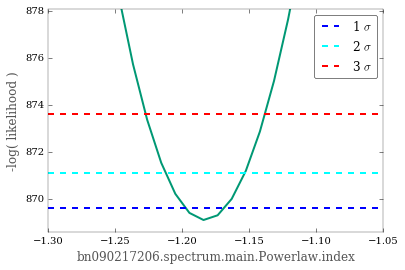

In [10]:
res = jl.get_contours(powerlaw.index,-1.3,-1.1,20)

In [11]:
%debug

> <ipython-input-2-8091d91cc005>(3)<module>()
      1 #This declares which data we want to use. In our case, all that we have already created.
      2 
----> 3 data_list = DataList( NaI6 )

ipdb> 

KeyboardInterrupt


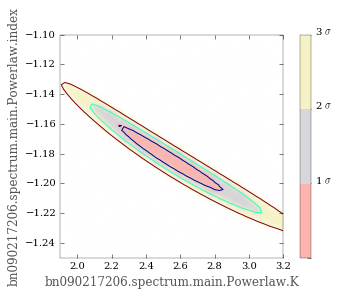

In [12]:
res = jl.get_contours(powerlaw.index,-1.25,-1.1,50,powerlaw.K,1.9,3.2,50)

In [13]:
powerlaw.index.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
powerlaw.K.prior = Log_uniform_prior(lower_bound=1.0, upper_bound=10)

bayes = BayesianAnalysis(model, data_list)

In [14]:
l = Log_uniform_prior(lower_bound=1.0, upper_bound=10.0)

l(2.0)

array(0.5)

In [15]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

#Running burn-in of 100 samples...

# [*********************100%***********************]  100 of 100 completed in 2.4 s

#Sampling...

# [*********************100%***********************]  1000 of 1000 completed in 22.6 s
#Mean acceptance fraction: 0.71655

Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.71194


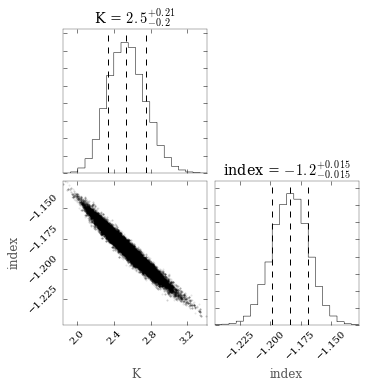

In [16]:
fig = bayes.corner_plot(plot_contours=False, plot_density=False)

In [17]:
sp = SpectralPlotter(jl)

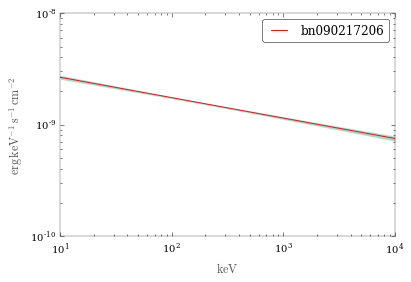

In [18]:
sp.plot_model()

In [19]:
sp = SpectralPlotter(bayes)

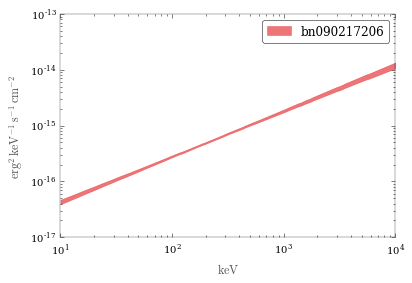

In [21]:
sp.plot_model(y_unit='erg2/(cm2 s) keV')